# **Análisis de grandes volumenes de datos**

## Maestría en Inteligencia Artificial Aplicada
#### Tecnológico de Monterrey

### **Actividad 5 | Actividad de visualización de resultados**

* **Número de Equipo: 47**

*   Luis Felipe Neri Alvarado Fregoso
*   Gustavo Adolfo Benitez Leonés
*   Jorge Oswaldo Trujillo Peña
*   Wilberth Eduardo López Gómez

## Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rand
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from functools import reduce
import warnings
warnings.filterwarnings('ignore')

In [ ]:
spark = (
    SparkSession.builder
    .master("local[12]")
    .appName("Actividad5_ValidacionCruzada")
    .config("spark.driver.memory", "24g")
    .config("spark.sql.shuffle.partitions", "24")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/16 19:56:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Preprocesamiento

In [ ]:
PATH_TO_DATA = '/home/gbenitezl/Downloads/mxmortality_rev.parquet'
df_base = spark.read.parquet(PATH_TO_DATA)

print(f"Dataset cargado con {df_base.count()} registros")

Dataset cargado con 7578742 registros


In [ ]:
# Preprocesamiento y creación de variables de caracterización
df_feat = df_base.filter(
    (F.year("decease_date") >= 2012) & (F.year("decease_date") <= 2022)
).withColumn(
    "age", F.floor(F.datediff("decease_date", "birth_date") / 365.25)
).withColumn(
    "month", F.month("decease_date")
).withColumn(
    "age_grp",
    F.when(F.col("age") < 5, "0-4")
     .when((F.col("age") >= 5) & (F.col("age") <= 14), "5-14")
     .when((F.col("age") >= 15) & (F.col("age") <= 24), "15-24")
     .when((F.col("age") >= 25) & (F.col("age") <= 44), "25-44")
     .when((F.col("age") >= 45) & (F.col("age") <= 64), "45-64")
     .otherwise("65+")
)

In [ ]:
def group_causa(desc):
    if desc is None: return "Otras Causas"
    desc_lower = desc.lower()
    if any(k in desc_lower for k in ["víricas", "infecciosas", "bacterianas", "tuberculosis", "rickettsiosis"]): return "Enfermedades Infecciosas"
    if "tumor" in desc_lower: return "Neoplasias (Tumores)"
    if any(k in desc_lower for k in ["endocrinas", "metabólicas", "nutricionales", "diabetes"]): return "Enfermedades Endocrinas y Metabólicas"
    if any(k in desc_lower for k in ["isquémicas", "hipertensivas", "corazón", "circulatorio", "cerebrovasculares"]): return "Enfermedades del Sistema Circulatorio"
    if "respiratorio" in desc_lower: return "Enfermedades del Sistema Respiratorio"
    if "digestivo" in desc_lower: return "Enfermedades del Sistema Digestivo"
    if any(k in desc_lower for k in ["agresiones", "accidentes", "autoinfligidas", "violencia", "caídas", "envenenamiento"]): return "Causas Externas de Mortalidad"
    if "perinatal" in desc_lower: return "Afecciones Perinatales"
    return "Otras Causas"

In [ ]:
group_causa_udf = F.udf(group_causa, StringType())
df_grouped = df_feat.withColumn("causa_agrupada", group_causa_udf(F.col("desc")))

# Muestreo estratificado para crear la muestra M
df_with_key = df_grouped.withColumn(
    "strat_key", F.concat_ws("_", F.col("age_grp"), F.col("causa_agrupada"))
)

sample_fraction = 0.1  # 10% de cada estrato
fractions = (
    df_with_key.select("strat_key").distinct()
    .withColumn("fraction", F.lit(sample_fraction))
    .rdd.collectAsMap()
)

muestra_M = df_with_key.stat.sampleBy(col="strat_key", fractions=fractions, seed=1).drop("strat_key")
muestra_M.cache()

print(f"Muestra M construida con {muestra_M.count()} registros")

25/06/16 19:57:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Muestra M construida con 756373 registros


Como parte del preprocesamiento del dataset, se filtraron los registros del conjunto original para considerar únicamente los fallecimientos ocurridos entre los años 2012 y 2022, donde se generaron variables de la población, como la edad (age), el mes de fallecimiento (decease_date) y la categoria por edad (age_grp), además de que se agruparon las causas de muerte en categorías generales. Para construir una muestra representativa de la población necesaria para aplicar validación cruzada sin procesar el total del volumen de datos se implementó un muestreo estratificado utilizando como claves de estratificación la combinación entre age_grp y causa_agrupada. Con una fracción de muestreo del 10% por estrato, se obtuvo una muestra final mayor de 756,000 registros, garantizando así diversidad y equilibrio en la distribución de clases dentro de la muestra M.

## Definición de y argumentación del Valor para K-Folds

Argumentación para la selección de K=5:


1. Representatividad estadística

La muestra M (~750 000 registros) se divide en 5 folds de ≃150 000 cada uno. Así, incluso los estratos más pequeños (5 instancias) aportan al menos una muestra por fold, manteniendo la estratificación.
Con más de 5 folds, algunos estratos de sólo 5 registros no podrían aparecer en cada fold, perdiendo representatividad.

2. Consideraciones de Big Data y costo computacional

Validación con k=5 implica 5 folds × 5 valores de k_clusters (3–7) = 25 entrenamientos de K-Means sobre ≃150 000 registros cada uno, un volumen viable en pocos minutos con 12 núcleos y 24 GB de RAM.
Usar k=10 duplicaría entrenamientos (50) sin aportar mayor estabilidad, incrementando tiempo y recursos sin beneficio práctico.

3. Estabilidad del clustering y relevancia de los folds

En clustering los folds no se usan para “entrenar y probar” en el sentido convencional, sino para evaluar la estabilidad de los patrones hallados.
Con 5 réplicas medimos media y desviación del Silhouette Score, confirmando que la elección de k_clusters es consistente y los clústeres se reproducen ante variaciones en los datos.

In [ ]:
k_folds = 5
fold_size = muestra_M.count() // k_folds
print(f"Configuración: k={k_folds} folds, ~{fold_size} registros por fold")

Configuración: k=5 folds, ~151274 registros por fold


## Construcción de los K-Folds

Se diseñó un procedimiento que mantiene la estratificación de la muestra según las dos variables clave (age_grp y causa_agrupada). Se asignaron índices aleatorios. A partir de estos índices, se asignó un número de fold de manera proporcional, asegurando que cada `fold` incluyera representaciones balanceadas de todos los estratos definidos.

In [ ]:
# Asignar índices aleatorios para dividir en folds manteniendo estratificación

# Crear índices aleatorios estratificados
window_spec = Window.partitionBy("age_grp", "causa_agrupada").orderBy(rand(seed=1))
df_with_fold_prep = muestra_M.withColumn("strat_row_num", row_number().over(window_spec))

# Calcular estadísticas por estrato para asignación proporcional de folds
strata_counts = (df_with_fold_prep
                .groupBy("age_grp", "causa_agrupada")
                .count()
                .collect())

In [ ]:
def assign_fold(strat_row_num, strat_count, k=5):
    # Distribución proporcional dentro de cada estrato
    fold_id = ((strat_row_num - 1) * k) // strat_count
    return min(fold_id, k - 1)  # Asegurar que fold_id esté en rango [0, k-1]

assign_fold_udf = F.udf(lambda x, y: int(assign_fold(x, y, k_folds)), "int")

In [ ]:
strata_count_dict = {}
for row in strata_counts:
    key = f"{row['age_grp']}_{row['causa_agrupada']}"
    strata_count_dict[key] = row['count']

# Broadcast del diccionario para eficiencia
strata_broadcast = spark.sparkContext.broadcast(strata_count_dict)

In [ ]:
def get_strata_count(age_grp, causa_agrupada):
    key = f"{age_grp}_{causa_agrupada}"
    return strata_broadcast.value.get(key, 1)

get_strata_count_udf = F.udf(get_strata_count, "int")

In [ ]:
df_with_folds = (df_with_fold_prep
    .withColumn("strat_count", get_strata_count_udf(F.col("age_grp"), F.col("causa_agrupada")))
    .withColumn("fold_id", assign_fold_udf(F.col("strat_row_num"), F.col("strat_count")))
    .drop("strat_row_num", "strat_count"))

df_with_folds.cache()

DataFrame[decease_date: string, birth_date: string, decease_date_UTC: string, decease_date_solar: string, decease_date_comp: string, tod: double, daylength: double, gdaylength: double, flux: double, gflux: double, lat: double, long: double, night: boolean, gr_lismex: string, desc: string, sexo: bigint, causa_def: string, Br: double, Bt: double, Bp: double, gBr: double, gBt: double, gBp: double, age: bigint, month: int, age_grp: string, causa_agrupada: string, fold_id: int]

In [ ]:
# Verificar distribución de folds
print("Distribución de registros por fold:")
fold_distribution = df_with_folds.groupBy("fold_id").count().orderBy("fold_id").collect()
for row in fold_distribution:
    print(f"  Fold {row.fold_id}: {row['count']} registros")

Distribución de registros por fold:


  Fold 0: 151292 registros
  Fold 1: 151271 registros
  Fold 2: 151278 registros
  Fold 3: 151271 registros
  Fold 4: 151261 registros


In [ ]:
# Verificar representatividad por estrato en cada fold
print("\nVerificación de representatividad por estrato en cada fold:")
strata_per_fold = (df_with_folds
    .groupBy("fold_id", "age_grp", "causa_agrupada")
    .count()
    .groupBy("fold_id")
    .count()
    .orderBy("fold_id")
    .collect())

for row in strata_per_fold:
    print(f"  Fold {row.fold_id}: {row['count']} estratos diferentes representados")


Verificación de representatividad por estrato en cada fold:
  Fold 0: 49 estratos diferentes representados
  Fold 1: 49 estratos diferentes representados
  Fold 2: 49 estratos diferentes representados
  Fold 3: 49 estratos diferentes representados
  Fold 4: 49 estratos diferentes representados


## Entrenamiento de los Folds

In [ ]:
# Preparación de características
df_engineered = df_with_folds.withColumn("month_sin", F.sin(2 * np.pi * F.col("month") / 12)) \
                            .withColumn("month_cos", F.cos(2 * np.pi * F.col("month") / 12))

categorical_cols = ["sexo", "age_grp"]
numerical_cols = ["age", "month_sin", "month_cos", "daylength", "flux", "lat", "long"]

In [ ]:
# Pipeline de preprocesamiento
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_cols]
assembler_inputs = numerical_cols + [f"{c}_idx" for c in categorical_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="unscaled_features", handleInvalid="skip")
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

pipeline_preproc = Pipeline(stages=indexers + [assembler, scaler])

In [ ]:
# Variables para almacenar resultados
fold_results = []
best_k_per_fold = []
silhouette_scores_all_folds = {}

# Evaluador de clustering
evaluator_silhouette = ClusteringEvaluator(
    featuresCol='features',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean'
)

In [ ]:
print("Iniciando experimentación por fold...")

for fold_id in range(k_folds):
    print(f"\n--- PROCESANDO FOLD {fold_id + 1}/{k_folds} ---")

    # Preparar datos del fold actual
    fold_data = df_engineered.filter(F.col("fold_id") == fold_id)
    fold_count = fold_data.count()
    print(f"Registros en fold {fold_id}: {fold_count}")

    if fold_count < 50:  # Verificar tamaño mínimo
        print(f"Fold {fold_id} muy pequeño, saltando...")
        continue

    # Aplicar preprocesamiento
    preproc_model = pipeline_preproc.fit(fold_data)
    data_for_clustering = preproc_model.transform(fold_data)
    data_for_clustering.cache()

    # Buscar mejor k para este fold
    fold_silhouette_scores = {}
    best_k_fold = 3
    best_score_fold = -1

    print(f"Buscando mejor k para fold {fold_id}...")
    for k_clusters in range(3, 8):
        try:
            kmeans = KMeans(featuresCol='features', k=k_clusters, seed=1)
            model = kmeans.fit(data_for_clustering)
            predictions = model.transform(data_for_clustering)

            score = evaluator_silhouette.evaluate(predictions)
            fold_silhouette_scores[k_clusters] = score

            print(f"  k={k_clusters}: Silhouette = {score:.4f}")

            if score > best_score_fold:
                best_score_fold = score
                best_k_fold = k_clusters

        except Exception as e:
            print(f"  Error con k={k_clusters}: {str(e)}")
            fold_silhouette_scores[k_clusters] = -1

    # Entrenar modelo final con mejor k
    print(f"Mejor k para fold {fold_id}: {best_k_fold} (Silhouette: {best_score_fold:.4f})")

    kmeans_final = KMeans(featuresCol='features', k=best_k_fold, seed=1)
    final_model = kmeans_final.fit(data_for_clustering)
    final_predictions = final_model.transform(data_for_clustering)

    # Calcular métricas finales
    final_silhouette = evaluator_silhouette.evaluate(final_predictions)
    wssse = final_model.summary.trainingCost
    cluster_sizes = final_model.summary.clusterSizes

    # Guardar resultados
    fold_result = {
        'fold_id': fold_id,
        'best_k': best_k_fold,
        'silhouette_score': final_silhouette,
        'wssse': wssse,
        'cluster_sizes': cluster_sizes,
        'n_samples': fold_count,
        'silhouette_by_k': fold_silhouette_scores
    }

    fold_results.append(fold_result)
    best_k_per_fold.append(best_k_fold)
    silhouette_scores_all_folds[fold_id] = fold_silhouette_scores

    data_for_clustering.unpersist()
    print(f"Fold {fold_id} completado. Silhouette final: {final_silhouette:.4f}")

print(f"\nExperimentación completada. {len(fold_results)} folds procesados exitosamente.")

Iniciando experimentación por fold...

--- PROCESANDO FOLD 1/5 ---
Registros en fold 0: 151292
Buscando mejor k para fold 0...


25/06/16 19:57:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


  k=3: Silhouette = 0.3225
  k=4: Silhouette = 0.3340
  k=5: Silhouette = 0.2673
  k=6: Silhouette = 0.2326
  k=7: Silhouette = 0.2610
Mejor k para fold 0: 4 (Silhouette: 0.3340)
Fold 0 completado. Silhouette final: 0.3340

--- PROCESANDO FOLD 2/5 ---
Registros en fold 1: 151271
Buscando mejor k para fold 1...
  k=3: Silhouette = 0.3230
  k=4: Silhouette = 0.3346
  k=5: Silhouette = 0.3221
  k=6: Silhouette = 0.2790
  k=7: Silhouette = 0.2718
Mejor k para fold 1: 4 (Silhouette: 0.3346)
Fold 1 completado. Silhouette final: 0.3346

--- PROCESANDO FOLD 3/5 ---
Registros en fold 2: 151278
Buscando mejor k para fold 2...
  k=3: Silhouette = 0.3222
  k=4: Silhouette = 0.2729
  k=5: Silhouette = 0.2898
  k=6: Silhouette = 0.2789
  k=7: Silhouette = 0.2724
Mejor k para fold 2: 3 (Silhouette: 0.3222)
Fold 2 completado. Silhouette final: 0.3222

--- PROCESANDO FOLD 4/5 ---
Registros en fold 3: 151271
Buscando mejor k para fold 3...
  k=3: Silhouette = 0.3229
  k=4: Silhouette = 0.2711
  k=5: Sil

## Resultados y Visualización

In [ ]:
# Convertir resultados a DataFrame de pandas para visualización
results_df = pd.DataFrame([{
    'Fold': r['fold_id'],
    'Mejor_K': r['best_k'],
    'Silhouette_Score': r['silhouette_score'],
    'WSSSE': r['wssse'],
    'N_Muestras': r['n_samples'],
    'Num_Clusters': len(r['cluster_sizes']),
    'Cluster_Sizes': str(r['cluster_sizes'])
} for r in fold_results])

print("Resumen de resultados por fold:")
print(results_df.to_string(index=False))

Resumen de resultados por fold:
 Fold  Mejor_K  Silhouette_Score         WSSSE  N_Muestras  Num_Clusters                Cluster_Sizes
    0        4          0.334007 836218.996396      151292             4 [53715, 15241, 59165, 23171]
    1        4          0.334597 835841.894942      151271             4 [53935, 23253, 14947, 59136]
    2        3          0.322224 953226.382891      151278             3        [59696, 25148, 66434]
    3        3          0.322865 952951.260057      151271             3        [66479, 59695, 25097]
    4        4          0.334496 836074.851064      151261             4 [53776, 14947, 23211, 59327]


Se resumen los resultados de los cinco folds, mostrando el mejor valor de
𝑘, el Silhouette Score, el WSSSE y la cantidad de clusters formados. La métrica de Silhouette fue consistente entre folds (0.3222 a 0.3346), con predominancia de 𝑘=4, lo que indica estabilidad en los agrupamientos generados. Los tamaños de cluster fueron balanceados, sin grupos desproporcionados.

In [ ]:
# Estadísticas de variabilidad
silhouette_mean = results_df['Silhouette_Score'].mean()
silhouette_std = results_df['Silhouette_Score'].std()
k_mode = results_df['Mejor_K'].mode()[0]

print(f"\n=== ESTADÍSTICAS DE VARIABILIDAD ===")
print(f"Silhouette Score - Media: {silhouette_mean:.4f}")
print(f"Silhouette Score - Desviación Estándar: {silhouette_std:.4f}")
print(f"Silhouette Score - Coeficiente de Variación: {(silhouette_std/silhouette_mean)*100:.2f}%")
print(f"Mejor K más frecuente: {k_mode}")
print(f"Rango de Silhouette Scores: [{results_df['Silhouette_Score'].min():.4f}, {results_df['Silhouette_Score'].max():.4f}]")


=== ESTADÍSTICAS DE VARIABILIDAD ===
Silhouette Score - Media: 0.3296
Silhouette Score - Desviación Estándar: 0.0065
Silhouette Score - Coeficiente de Variación: 1.97%
Mejor K más frecuente: 4
Rango de Silhouette Scores: [0.3222, 0.3346]


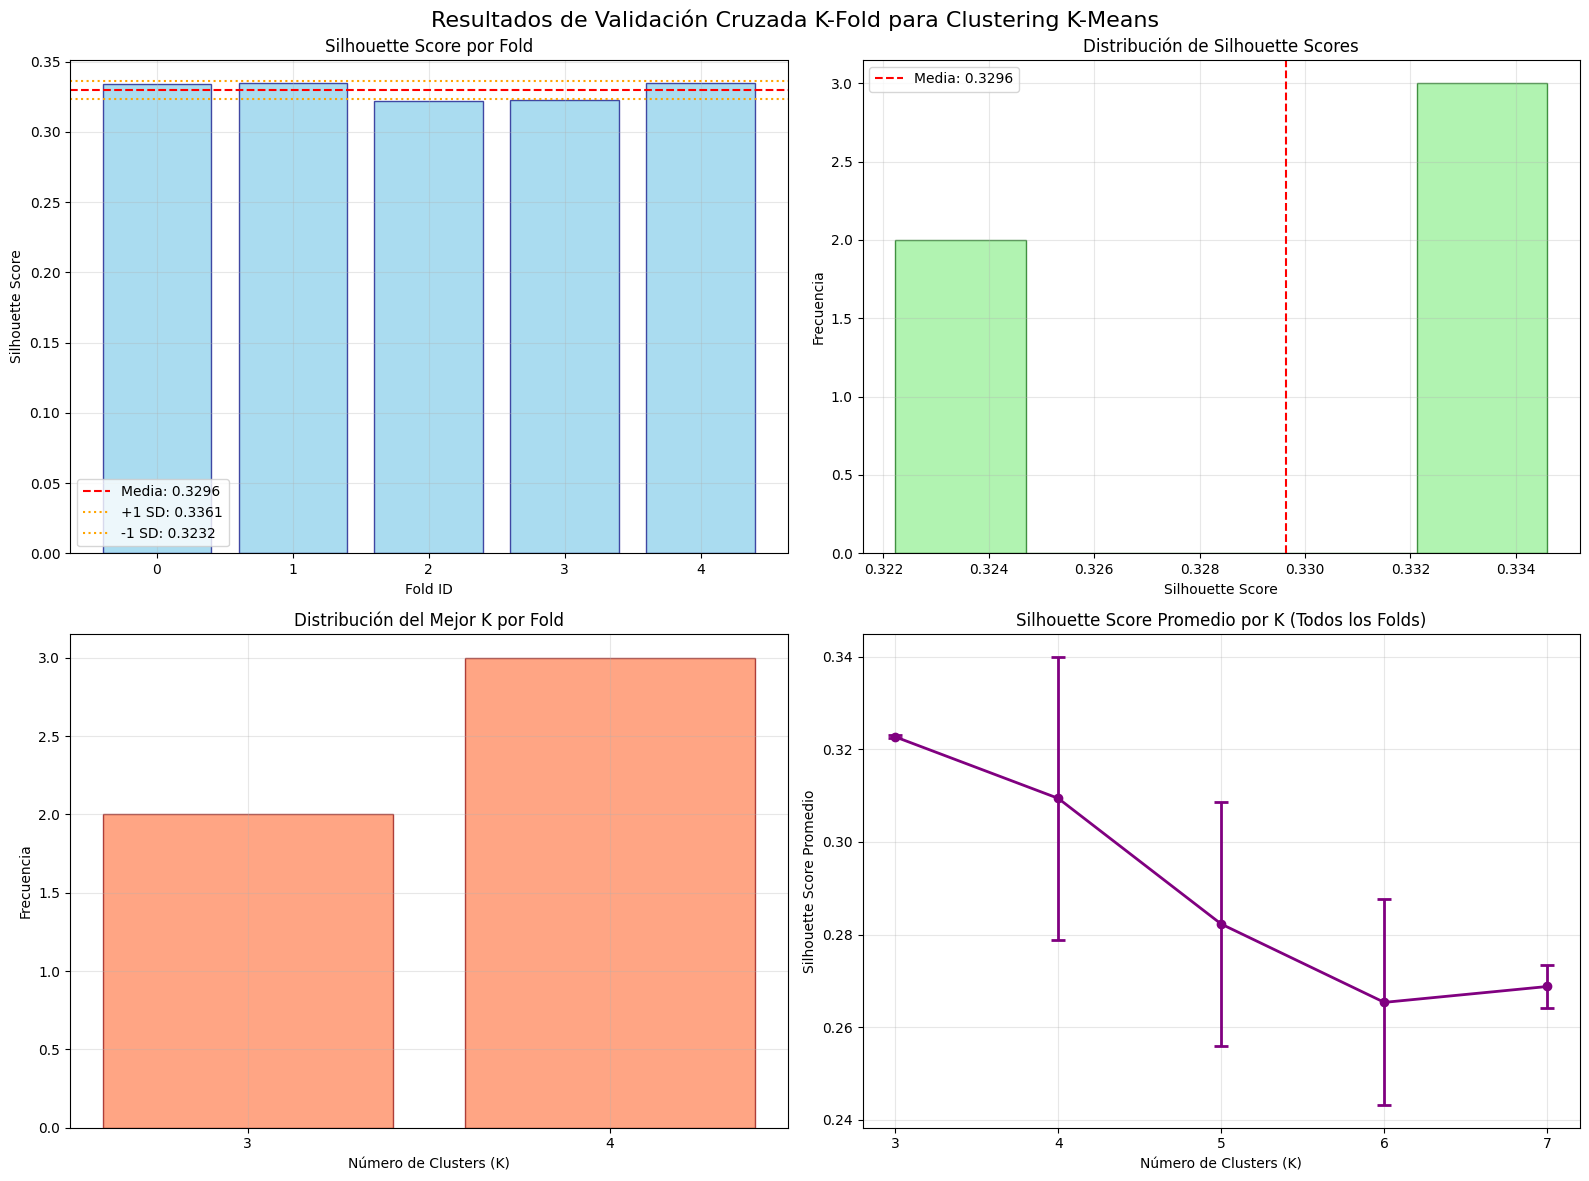

In [ ]:
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Resultados de Validación Cruzada K-Fold para Clustering K-Means', fontsize=16)

# 1. Silhouette Score por Fold
axes[0, 0].bar(results_df['Fold'], results_df['Silhouette_Score'],
               color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].axhline(y=silhouette_mean, color='red', linestyle='--',
                   label=f'Media: {silhouette_mean:.4f}')
axes[0, 0].axhline(y=silhouette_mean + silhouette_std, color='orange', linestyle=':',
                   label=f'+1 SD: {silhouette_mean + silhouette_std:.4f}')
axes[0, 0].axhline(y=silhouette_mean - silhouette_std, color='orange', linestyle=':',
                   label=f'-1 SD: {silhouette_mean - silhouette_std:.4f}')
axes[0, 0].set_title('Silhouette Score por Fold')
axes[0, 0].set_xlabel('Fold ID')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribución de Silhouette Scores
axes[0, 1].hist(results_df['Silhouette_Score'], bins=len(fold_results),
                color='lightgreen', edgecolor='darkgreen', alpha=0.7)
axes[0, 1].axvline(x=silhouette_mean, color='red', linestyle='--',
                   label=f'Media: {silhouette_mean:.4f}')
axes[0, 1].set_title('Distribución de Silhouette Scores')
axes[0, 1].set_xlabel('Silhouette Score')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Mejor K por Fold
k_counts = results_df['Mejor_K'].value_counts().sort_index()
axes[1, 0].bar(k_counts.index, k_counts.values,
               color='coral', edgecolor='darkred', alpha=0.7)
axes[1, 0].set_title('Distribución del Mejor K por Fold')
axes[1, 0].set_xlabel('Número de Clusters (K)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_xticks(k_counts.index)
axes[1, 0].grid(True, alpha=0.3)

# 4. Evolución de Silhouette por K (promedio de todos los folds)
k_values = range(3, 8)
avg_silhouette_by_k = []
std_silhouette_by_k = []

for k in k_values:
    scores = [silhouette_scores_all_folds[fold_id].get(k, np.nan)
              for fold_id in silhouette_scores_all_folds.keys()]
    scores = [s for s in scores if not np.isnan(s) and s > -1]  # Filtrar valores válidos

    if scores:
        avg_silhouette_by_k.append(np.mean(scores))
        std_silhouette_by_k.append(np.std(scores))
    else:
        avg_silhouette_by_k.append(0)
        std_silhouette_by_k.append(0)

axes[1, 1].errorbar(k_values, avg_silhouette_by_k, yerr=std_silhouette_by_k,
                    marker='o', capsize=5, capthick=2, color='purple', linewidth=2)
axes[1, 1].set_title('Silhouette Score Promedio por K (Todos los Folds)')
axes[1, 1].set_xlabel('Número de Clusters (K)')
axes[1, 1].set_ylabel('Silhouette Score Promedio')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_values)

plt.tight_layout()
plt.show()

Las gráficas permiten observar que los valores de Silhouette Score son estables entre los distintos folds, con una media de 0.3296 y baja desviación. La mayoría de los folds seleccionaron k=4 como el número óptimo de clusters, aunque también se observó un buen desempeño con k=3. Además, la gráfica también muestra una disminución progresiva en el Silhouette promedio a medida que aumenta k, lo cual respalda la selección de valores bajos de k como óptimos. Estas visualizaciones confirman que el modelo es consistente y generaliza bien en diferentes subconjuntos de datos.

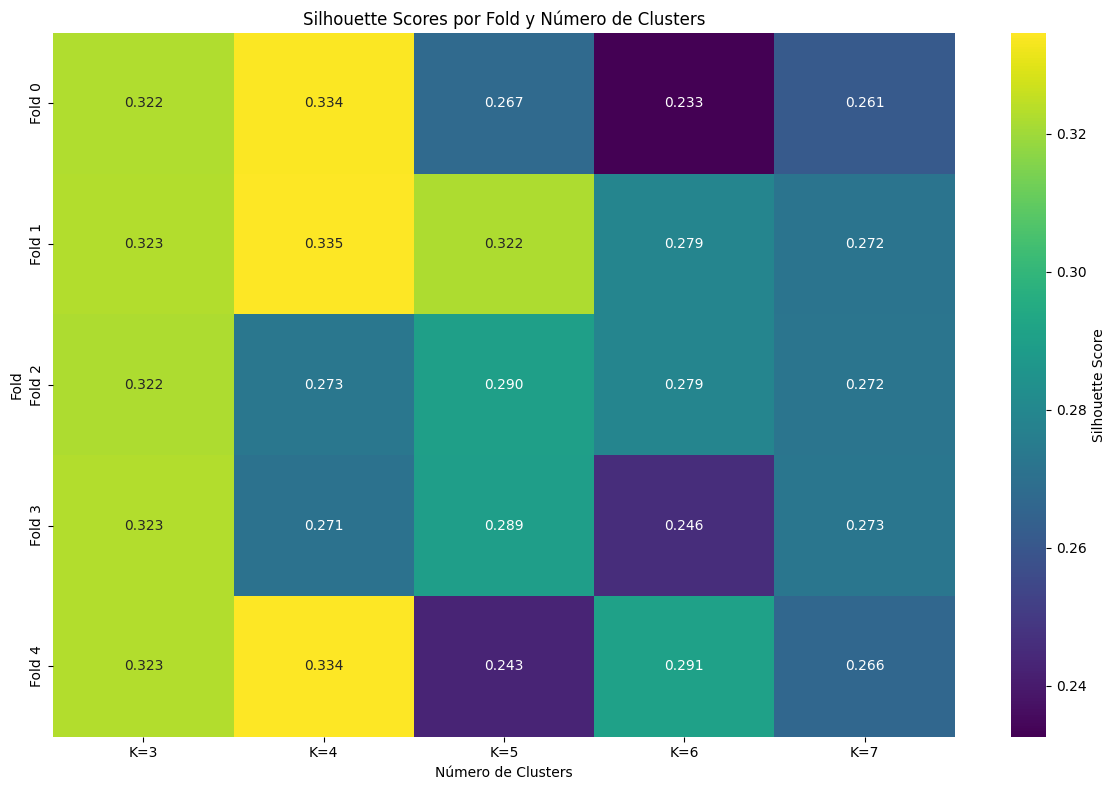

In [ ]:
plt.figure(figsize=(12, 8))

# Preparar datos para heatmap
heatmap_data = []
for fold_id in silhouette_scores_all_folds.keys():
    row = []
    for k in range(3, 8):
        score = silhouette_scores_all_folds[fold_id].get(k, np.nan)
        row.append(score if not np.isnan(score) and score > -1 else 0)
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data,
                         index=[f'Fold {i}' for i in range(len(heatmap_data))],
                         columns=[f'K={k}' for k in range(3, 8)])

sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='viridis',
            cbar_kws={'label': 'Silhouette Score'})
plt.title('Silhouette Scores por Fold y Número de Clusters')
plt.ylabel('Fold')
plt.xlabel('Número de Clusters')
plt.tight_layout()
plt.show()

El mapa de calor muestra los puntajes de Silhouette para cada combinación de fold y número de clusters (k). Se observa que k=4 obtiene los valores más altos de manera consistente en la mayoría de los folds, seguido por k=3, mientras que valores más altos de k tienden a tener puntajes más bajos. Esta visualización refuerza la elección de k óptimos bajos (3 o 4), confirmando que el modelo generaliza bien sin necesidad de sobresegmentar los datos.

### Conclusion:

Los resultados obtenidos a través del proceso de validación cruzada con 5 folds muestran una alta estabilidad en el rendimiento del modelo de clustering K-Means, evaluado mediante la métrica de Silhouette Score. En todos los folds, los valores de Silhouette se mantuvieron dentro de un rango estrecho (entre 0.3222 y 0.3346), lo que indica que la calidad del agrupamiento no varió significativamente entre subconjuntos de datos.

De mismo modo, la elección del número de clusters k fue coherente entre folds: k=4 fue seleccionado como óptimo en 4 de los 5 casos, y k=3 en el restante. Esto sugiere que los patrones de agrupamiento presentes en la muestra para la práctica son efectivos. Las visualizaciones de barras, distribuciones y mapa de calor reforzaron estos hallazgos al poder ver de manera visual su comportamiento.

Finalmente, se cumplió de manera exitosa el objetivo de esta actividad: validar la estabilidad del algoritmo seleccionado en la Actividad 4 mediante una metodología de validación cruzada adaptada con enfoque en Big Data. El modelo no mostró signos de sobreajuste y los clusters generados fueron estables, por lo que se concluye que los patrones encontrados son confiables y relevantes para el análisis de la población en estudio.